# Task Overview

Implemented here is a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

Used here is an MLP architecture trained on the MNIST dataset. The network itself is implemented in numpy.

In [ ]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.9.0
    Uninstalling PyJWT-2.9.0:
      Successfully uninstalled PyJWT-2.9.0


In [ ]:
import numpy as np
from clearml import Logger
from typing import List

In [ ]:
%load_ext memory_profiler

# Dataset loading


In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-11-16 12:35:49--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.17.47, 52.216.131.5, 52.216.97.165, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.17.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  15.0MB/s    in 0.7s    

2024-11-16 12:35:50 (15.0 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [ ]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
from clearml import Task
from google.colab import userdata

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = userdata.get('ACCESS_KEY')
secret_key = userdata.get('SECRET_KEY')

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition


In [ ]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [ ]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        np.random.seed(0) # reproducibility
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.6907, Loss: 2.010767895683771
Epoch: 1, Accuracy: 0.8502, Loss: 0.688922299888477


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 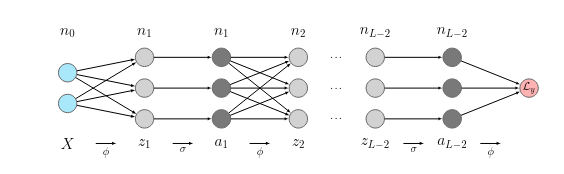)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 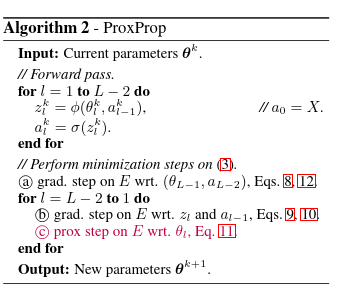)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 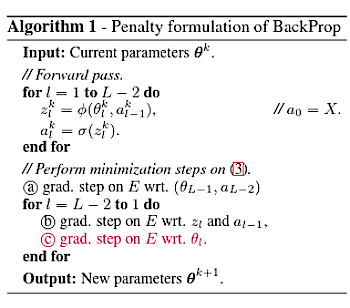)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

The task is to implement an algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.


In [ ]:
#@title Helper functions
# I grouped the functions here to make it easier

import matplotlib.pyplot as plt

def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))

def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

def plot_metrics(n_epochs: int, accs: List[float], losses: List[float]) -> None:
    # my plots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(range(1, n_epochs + 1), losses, color='blue')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, n_epochs + 1), accs, color='green')
    axs[1].set_title('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy [%]')

    plt.tight_layout()
    plt.show()



Epoch: 0, Accuracy: 0.6907, Loss: 2.010767895683771
Epoch: 1, Accuracy: 0.8502, Loss: 0.688922299888477


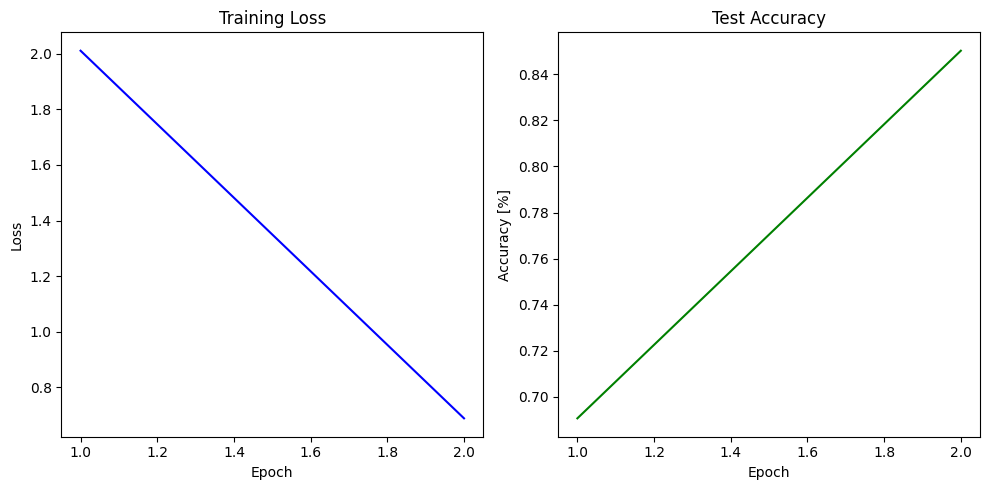

In [ ]:
#@title Basic Network with Standard Backpropagation and Standardized SGD
# Standardized SGD to match ProxProp (with logger and stuff)
# plus random seed for initialization for reproducibility

class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a

        np.random.seed(0)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)


        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)

        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)


        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]

        self.weights = [
            w - (eta / x.shape[1]) * nw for w, nw in zip(self.weights, dLdWs)
        ]
        self.biases = [
            b - (eta / x.shape[1]) * nb for b, nb in zip(self.biases, dLdBs)
        ]

        return loss

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        accs = []
        wlosses = []
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    i * mini_batch_size : (i * mini_batch_size + mini_batch_size)
                ]
                y_mini_batch = y_train[
                    i * mini_batch_size : (i * mini_batch_size + mini_batch_size)
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            wlosses.append(wloss)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                accs.append(acc)
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if logger:
                logger.report_scalar(title='Loss', series='Train', iteration=j, value=wloss)
                logger.report_scalar(title='Accuracy', series='Test', iteration=j, value=acc)
        plot_metrics(epochs, accs, wlosses)


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)
# gives the same result as the Network class above

ClearML Task: created new task id=8a6fdc5000ed407ebfe6af0625cf1fec
2024-11-16 12:36:13,390 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/9246654ea2844ca7a9ce0631cff53bad/experiments/8a6fdc5000ed407ebfe6af0625cf1fec/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch: 0, Accuracy: 0.605, Loss: 4.127916517640689
Epoch: 1, Accuracy: 0.862, Loss: 1.3484858121634968
Epoch: 2, Accuracy: 0.8932, Loss: 0.5278210923419857
Epoch: 3, Accuracy: 0.9073, Loss: 0.44010937182263926
Epoch: 4, Accuracy: 0.916, Loss: 0.3916064914600687
Epoch: 5, Accuracy: 0.9203, Loss: 0.35854323969647744
Epoch: 6, Accuracy: 0.9231, Loss: 0.33336478983950973
Epoch: 7, Accuracy: 0.9251, Loss: 0.313694580752248
Epoch: 8, Accuracy: 0.9266, Loss: 0.29775711175766734
Epoch: 9, Accuracy: 0.929, Loss: 0.2842502994990822
Epoch: 10, Accuracy: 0.9315, Loss: 0.2725420827493945
Epoch: 11, Accuracy: 0.933, Los

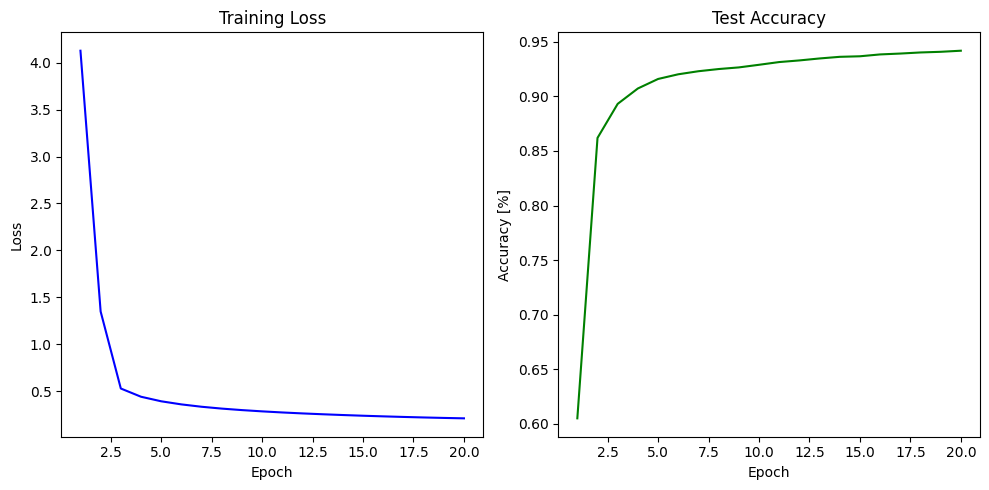

In [ ]:
#@title Basic Network's test - baseline for ProxProp
task = Task.init(project_name='dnn_hw1', task_name='test_basic')
task.mark_started()
logger = task.get_logger()

config = {
    'n_epochs': 20,
    'lr': 3.0,
    'mini_batch_size' : 100
}
task.connect(config)

network = Network([784, 128, 64, 10]) # good enough
network.SGD(
    (x_train, y_train),
    epochs=config['n_epochs'],
    mini_batch_size=config['mini_batch_size'],
    eta=config['lr'],
    test_data=(x_test, y_test),
    logger=logger
)

task.close()

Epoch: 0, Accuracy: 0.6963, Loss: 2.037107852263394
Epoch: 1, Accuracy: 0.8503, Loss: 0.8873851598606706


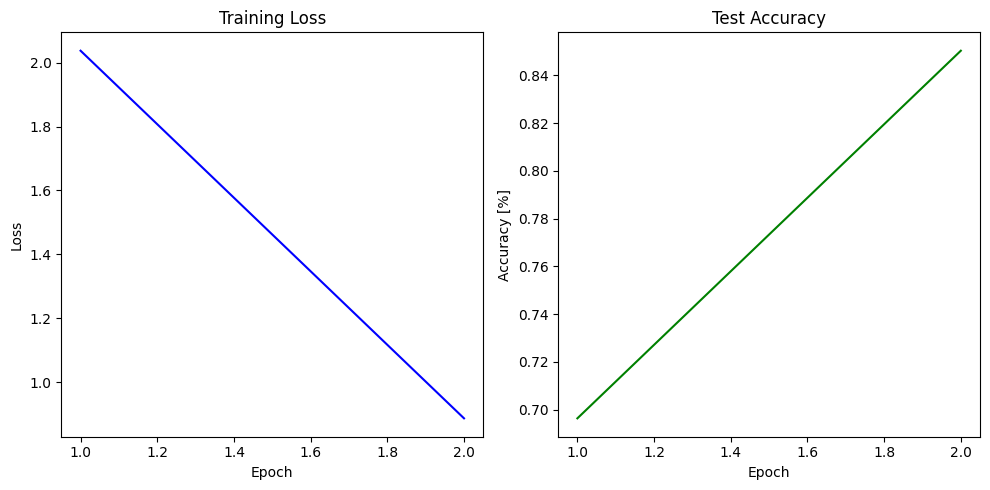

In [ ]:
#@title ProxProp Network
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a
        np.random.seed(0)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        a = a.T
        for b, w in zip(self.biases, self.weights, strict=True):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        # here, backprop() does both backpropagation and parameter updates
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights, strict=True):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)

        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)

        g_star = gs[-1] - eta * dLdg
        f_stars = []

        dLdfs = []
        for w, g, g1, f in reversed(list(zip(self.weights, gs[1:], gs[:-1], fs, strict=True))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

            f_star = f - (g * (1 - g)) * (g - g_star)
            # f_star = f - dg/df * (g - g_star)
            # dg/df = d(sigmoid(f))/df = sigmoid'(f) = g(1-g)
            f_stars.append(f_star)

            g_star = g1 - w.T @ (f - f_star)
            # g_star_l = g_l - df_l+1/dg_l * (f_l+1 - f_star_l+1)
            # df/dg = d(wg+b)/dg = w

        f_stars.reverse()

        dLdBs = [np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)]

        # new weights (closed-form) => solution to d(0.5(W @ g + b - f_star)^2 + (W - w)^2 / (2 * eta))/dW = 0
        # accounting for batch size by dividing lr by batch size => (eta / batch_size)
        # possible improvement by implementing sherman-morrison formula
        self.weights = [
            (f_star @ g.T - b @ np.sum(g, axis=1).reshape(g.shape[0], 1).T + (x.shape[1] / eta) * w) @ np.linalg.inv(g @ g.T + (x.shape[1] / eta) * np.identity(g.shape[0])) for (w, b, f_star, g) in zip(self.weights, self.biases, f_stars, gs[:-1], strict=True)
        ]

        self.biases = [
            b - (eta / x.shape[1]) * nb for b, nb in zip(self.biases, dLdBs, strict=True)
        ]

        return loss

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        accs = []
        wlosses = []
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    i * mini_batch_size : (i * mini_batch_size + mini_batch_size)
                ]
                y_mini_batch = y_train[
                    i * mini_batch_size : (i * mini_batch_size + mini_batch_size)
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta) #
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            wlosses.append(wloss)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                accs.append(acc)
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if logger:
                logger.report_scalar(title='Loss', series='Train', iteration=j, value=wloss)
                logger.report_scalar(title='Accuracy', series='Test', iteration=j, value=acc)
        plot_metrics(epochs, accs, wlosses)


# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)


# Train the network

In [ ]:
%%capture

layers = [784, 128, 64, 10] # keep the good enough one

# # === 1st set of tests ===
# n_epochs = 20 # should let all converge
# etas = [1.0, 3.0, 5.0, 10.0]
# sizes = [50, 100, 200, 400]

# # General observations:
# # - higher eta, better accuracy, fast convergence
# # - smaller batch, better accuracy, but slower

# === 2nd set of tests ===
n_epochs = 15 #
etas = [10.0, 15.0, 20.0, 25.0, 30.0] # 20 is the sweet spot
sizes = [50] # fine tune for this batch size

# Plots from the tests are available in the images folder

for size in sizes:
    for eta in etas:
        task = Task.init(project_name='dnn_hw1', task_name=f'test_pp_lr{eta}_mbs{size}')
        task.mark_started()
        logger = task.get_logger()

        config = {
            'n_epochs': n_epochs,
            'lr': eta,
            'mini_batch_size': size
        }
        task.connect(config)

        network = ProxProp(layers)
        network.SGD(
            (x_train, y_train),
            epochs=config['n_epochs'],
            mini_batch_size=config['mini_batch_size'],
            eta=config['lr'],
            test_data=(x_test, y_test),
            logger=logger
        )

        task.close()

ClearML Task: created new task id=4fd47bf35f9f41e0a192ffadb4b5700d
ClearML results page: https://app.clear.ml/projects/9246654ea2844ca7a9ce0631cff53bad/experiments/4fd47bf35f9f41e0a192ffadb4b5700d/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Task: created new task id=0ae94facf1e24cb39678ee21e9e81521
ClearML results page: https://app.clear.ml/projects/9246654ea2844ca7a9ce0631cff53bad/experiments/0ae94facf1e24cb39678ee21e9e81521/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Task: created new task id=ffdeecc85372472db6aafa2c4481b115
ClearML results page: https://app.clear.ml/projects/9246654ea2844ca7a9ce0631cff53bad/experiments/ffdeecc85372472db6aafa2c4481b115/o

# Training plots for the best training

Epoch: 0, Accuracy: 0.9299, Loss: 0.6347324525623372
Epoch: 1, Accuracy: 0.9427, Loss: 0.3644688892219183
Epoch: 2, Accuracy: 0.9485, Loss: 0.29892399380907214
Epoch: 3, Accuracy: 0.9508, Loss: 0.2635822372430199
Epoch: 4, Accuracy: 0.9533, Loss: 0.23878229557201108
Epoch: 5, Accuracy: 0.957, Loss: 0.22056390984780952
Epoch: 6, Accuracy: 0.9584, Loss: 0.20171846618632372
Epoch: 7, Accuracy: 0.9586, Loss: 0.1918035531021761
Epoch: 8, Accuracy: 0.9613, Loss: 0.17973008113398709
Epoch: 9, Accuracy: 0.9606, Loss: 0.16710838083001336
Epoch: 10, Accuracy: 0.9634, Loss: 0.15434907918112425
Epoch: 11, Accuracy: 0.96, Loss: 0.15291320654430304
Epoch: 12, Accuracy: 0.9609, Loss: 0.14569698321902658
Epoch: 13, Accuracy: 0.9616, Loss: 0.1400206553251743
Epoch: 14, Accuracy: 0.961, Loss: 0.13523360266260212
Epoch: 15, Accuracy: 0.963, Loss: 0.12948600230349533
Epoch: 16, Accuracy: 0.9624, Loss: 0.1252243511981452
Epoch: 17, Accuracy: 0.9627, Loss: 0.12044238210912099
Epoch: 18, Accuracy: 0.964, Los

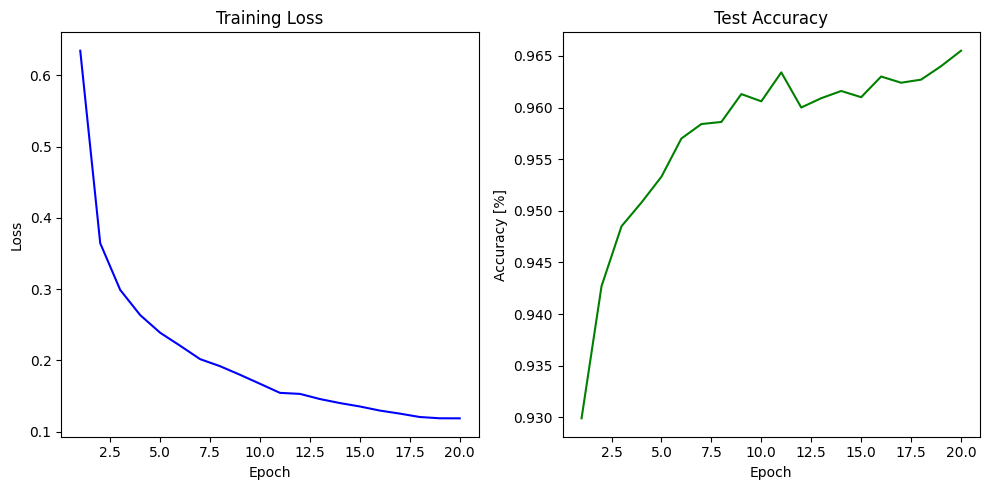

In [ ]:
# The best hyperparameter set from the tests for ProxProp

layers = [784, 128, 64, 10] # keep the good enough one
n_epochs = 20
eta = 20.0
mini_batch_size = 50
network = ProxProp(layers)
network.SGD(
    (x_train, y_train),
    epochs=n_epochs,
    mini_batch_size=mini_batch_size,
    eta=eta,
    test_data=(x_test, y_test)
)

# but...

Epoch: 0, Accuracy: 0.163, Loss: 27.51789916577995
Epoch: 1, Accuracy: 0.1631, Loss: 27.67628976560965
Epoch: 2, Accuracy: 0.1629, Loss: 27.675213055897625
Epoch: 3, Accuracy: 0.1629, Loss: 27.67412810851962
Epoch: 4, Accuracy: 0.1626, Loss: 27.6730347897654
Epoch: 5, Accuracy: 0.1624, Loss: 27.671932962641684
Epoch: 6, Accuracy: 0.1623, Loss: 27.670822486764532
Epoch: 7, Accuracy: 0.1622, Loss: 27.669703218246354
Epoch: 8, Accuracy: 0.1619, Loss: 27.6685750095783
Epoch: 9, Accuracy: 0.1619, Loss: 27.667437709508018
Epoch: 10, Accuracy: 0.1618, Loss: 27.66629116291214
Epoch: 11, Accuracy: 0.1618, Loss: 27.66513521066281
Epoch: 12, Accuracy: 0.1617, Loss: 27.663969689489168
Epoch: 13, Accuracy: 0.1618, Loss: 27.662794431832094
Epoch: 14, Accuracy: 0.162, Loss: 27.661609265693095
Epoch: 15, Accuracy: 0.1623, Loss: 27.66041401447609
Epoch: 16, Accuracy: 0.1622, Loss: 27.659208496822206
Epoch: 17, Accuracy: 0.1621, Loss: 27.65799252643725
Epoch: 18, Accuracy: 0.1621, Loss: 27.6567659119110

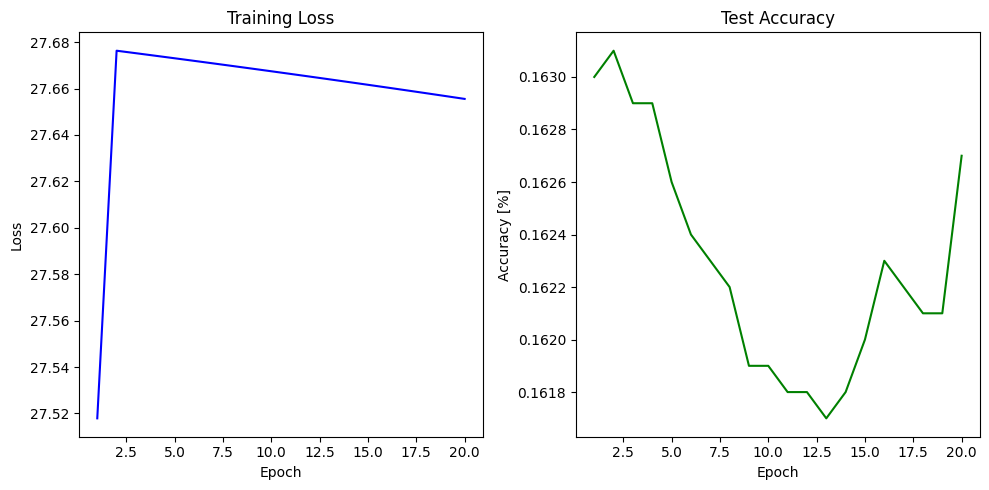

In [ ]:
# Same hyperparameters on the standard Network
# The standard Network doesn't even get off the ground
# most probably lr is too high and the model is overshooting(?)

layers = [784, 128, 64, 10] # keep the good enough one
n_epochs = 20
eta = 20.0
mini_batch_size = 50
network = Network(layers)
network.SGD(
    (x_train, y_train),
    epochs=n_epochs,
    mini_batch_size=mini_batch_size,
    eta=eta,
    test_data=(x_test, y_test)
)

Epoch: 0, Accuracy: 0.6891, Loss: 3.8185708502972937
Epoch: 1, Accuracy: 0.8842, Loss: 1.2678714055122546
Epoch: 2, Accuracy: 0.9144, Loss: 0.43834343200681786
Epoch: 3, Accuracy: 0.9245, Loss: 0.3666978054177733
Epoch: 4, Accuracy: 0.9299, Loss: 0.327059355822949
Epoch: 5, Accuracy: 0.9315, Loss: 0.29969689836535834
Epoch: 6, Accuracy: 0.9343, Loss: 0.27868402860703223
Epoch: 7, Accuracy: 0.9357, Loss: 0.2625298985864696
Epoch: 8, Accuracy: 0.9385, Loss: 0.2493449958666323
Epoch: 9, Accuracy: 0.9394, Loss: 0.23855989708389966
Epoch: 10, Accuracy: 0.9405, Loss: 0.22930068057900607
Epoch: 11, Accuracy: 0.9427, Loss: 0.22105806959123028
Epoch: 12, Accuracy: 0.9436, Loss: 0.21369054300513032
Epoch: 13, Accuracy: 0.9449, Loss: 0.20730684118038997
Epoch: 14, Accuracy: 0.9451, Loss: 0.20165709861457976
Epoch: 15, Accuracy: 0.9451, Loss: 0.19653370671985065
Epoch: 16, Accuracy: 0.9458, Loss: 0.19180041092051528
Epoch: 17, Accuracy: 0.9467, Loss: 0.18738883985788804
Epoch: 18, Accuracy: 0.9473

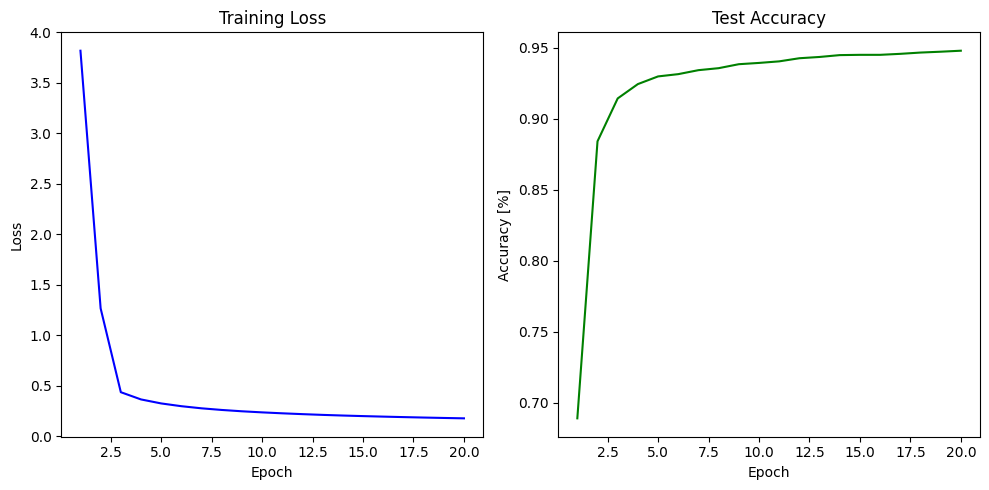

In [ ]:
# Backing off with learning rate to make both Networks comparable

# Standard Network
layers = [784, 128, 64, 10]
n_epochs = 20
eta = 5.0
mini_batch_size = 100
network = Network(layers)
network.SGD(
    (x_train, y_train),
    epochs=n_epochs,
    mini_batch_size=mini_batch_size,
    eta=eta,
    test_data=(x_test, y_test)
)


Epoch: 0, Accuracy: 0.8807, Loss: 1.037759243505767
Epoch: 1, Accuracy: 0.9122, Loss: 0.436294619059471
Epoch: 2, Accuracy: 0.924, Loss: 0.34839368401884546
Epoch: 3, Accuracy: 0.9305, Loss: 0.2974543836437498
Epoch: 4, Accuracy: 0.9352, Loss: 0.2632098312334268
Epoch: 5, Accuracy: 0.9383, Loss: 0.23881540161098325
Epoch: 6, Accuracy: 0.9407, Loss: 0.22054091429393813
Epoch: 7, Accuracy: 0.9427, Loss: 0.20692665908657645
Epoch: 8, Accuracy: 0.9452, Loss: 0.19614305322115647
Epoch: 9, Accuracy: 0.9466, Loss: 0.1870405459425804
Epoch: 10, Accuracy: 0.9467, Loss: 0.17927551910790165
Epoch: 11, Accuracy: 0.947, Loss: 0.17263130681622274
Epoch: 12, Accuracy: 0.9467, Loss: 0.166891256160567
Epoch: 13, Accuracy: 0.9468, Loss: 0.16213142437179323
Epoch: 14, Accuracy: 0.9473, Loss: 0.15806636741191848
Epoch: 15, Accuracy: 0.9474, Loss: 0.15456137430914435
Epoch: 16, Accuracy: 0.9466, Loss: 0.1514343973380941
Epoch: 17, Accuracy: 0.9467, Loss: 0.14843951818401738
Epoch: 18, Accuracy: 0.9468, Los

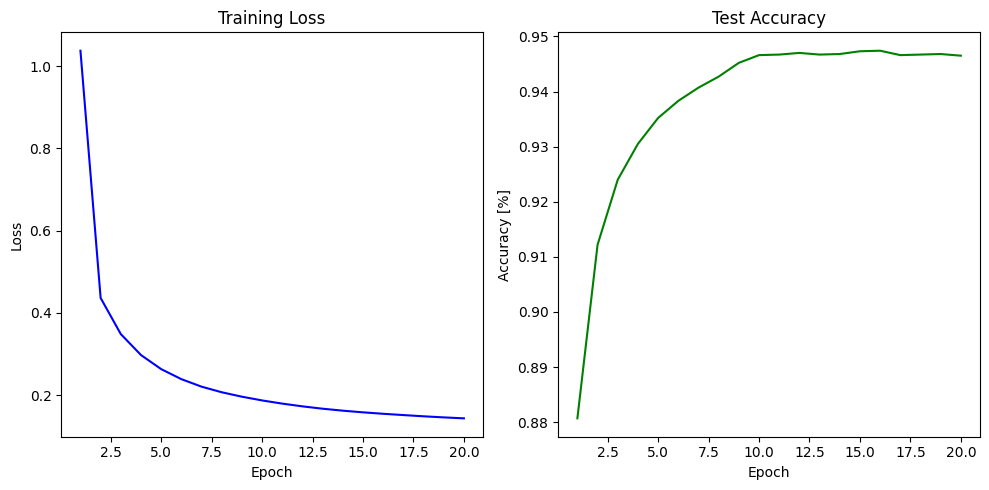

In [ ]:

# ProxProp Network with lowered learning rate
layers = [784, 128, 64, 10]
n_epochs = 20
eta = 5.0
mini_batch_size = 100
network = ProxProp(layers)
network.SGD(
    (x_train, y_train),
    epochs=n_epochs,
    mini_batch_size=mini_batch_size,
    eta=eta,
    test_data=(x_test, y_test)
)


# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

Epoch: 0, Accuracy: 0.6891, Loss: 3.8185708502972937
Epoch: 1, Accuracy: 0.8842, Loss: 1.2678714055122546
Epoch: 2, Accuracy: 0.9144, Loss: 0.43834343200681786
Epoch: 3, Accuracy: 0.9245, Loss: 0.3666978054177733
Epoch: 4, Accuracy: 0.9299, Loss: 0.327059355822949
Epoch: 5, Accuracy: 0.9315, Loss: 0.29969689836535834
Epoch: 6, Accuracy: 0.9343, Loss: 0.27868402860703223
Epoch: 7, Accuracy: 0.9357, Loss: 0.2625298985864696
Epoch: 8, Accuracy: 0.9385, Loss: 0.2493449958666323
Epoch: 9, Accuracy: 0.9394, Loss: 0.23855989708389966
Epoch: 10, Accuracy: 0.9405, Loss: 0.22930068057900607
Epoch: 11, Accuracy: 0.9427, Loss: 0.22105806959123028
Epoch: 12, Accuracy: 0.9436, Loss: 0.21369054300513032
Epoch: 13, Accuracy: 0.9449, Loss: 0.20730684118038997
Epoch: 14, Accuracy: 0.9451, Loss: 0.20165709861457976
Epoch: 15, Accuracy: 0.9451, Loss: 0.19653370671985065
Epoch: 16, Accuracy: 0.9458, Loss: 0.19180041092051528
Epoch: 17, Accuracy: 0.9467, Loss: 0.18738883985788804
Epoch: 18, Accuracy: 0.9473

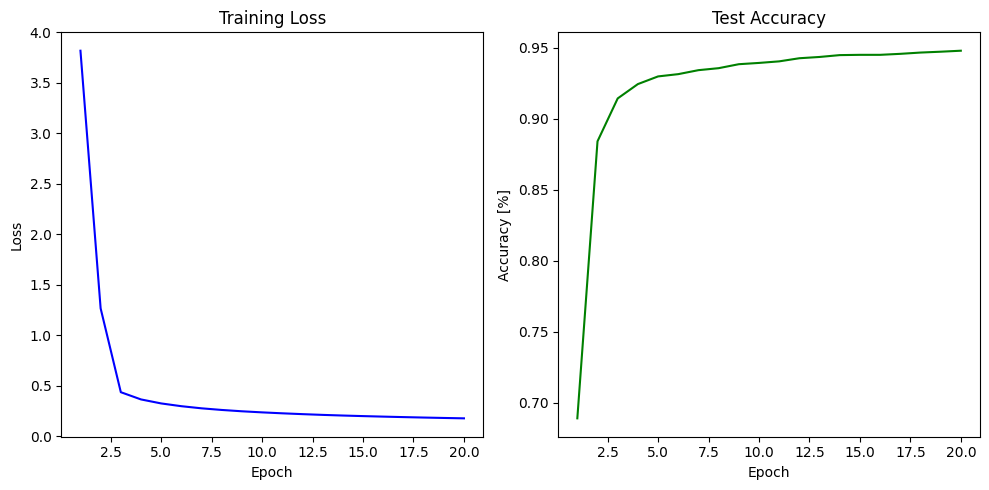

peak memory: 1646.47 MiB, increment: 0.07 MiB


In [ ]:
#@title Memory profiler on the Basic Network

# All other hyperparameters kept
layers = [784, 128, 64, 10]
n_epochs = 20
eta = 5.0
mini_batch_size = 100
network = Network(layers)
%memit network.SGD((x_train, y_train), epochs=n_epochs, mini_batch_size=mini_batch_size, eta=eta, test_data=(x_test, y_test))

# peak memory: 1646.47 MiB, increment: 0.07 MiB

Epoch: 0, Accuracy: 0.8807, Loss: 1.037759243505767
Epoch: 1, Accuracy: 0.9122, Loss: 0.436294619059471
Epoch: 2, Accuracy: 0.924, Loss: 0.34839368401884546
Epoch: 3, Accuracy: 0.9305, Loss: 0.2974543836437498
Epoch: 4, Accuracy: 0.9352, Loss: 0.2632098312334268
Epoch: 5, Accuracy: 0.9383, Loss: 0.23881540161098325
Epoch: 6, Accuracy: 0.9407, Loss: 0.22054091429393813
Epoch: 7, Accuracy: 0.9427, Loss: 0.20692665908657645
Epoch: 8, Accuracy: 0.9452, Loss: 0.19614305322115647
Epoch: 9, Accuracy: 0.9466, Loss: 0.1870405459425804
Epoch: 10, Accuracy: 0.9467, Loss: 0.17927551910790165
Epoch: 11, Accuracy: 0.947, Loss: 0.17263130681622274
Epoch: 12, Accuracy: 0.9467, Loss: 0.166891256160567
Epoch: 13, Accuracy: 0.9468, Loss: 0.16213142437179323
Epoch: 14, Accuracy: 0.9473, Loss: 0.15806636741191848
Epoch: 15, Accuracy: 0.9474, Loss: 0.15456137430914435
Epoch: 16, Accuracy: 0.9466, Loss: 0.1514343973380941
Epoch: 17, Accuracy: 0.9467, Loss: 0.14843951818401738
Epoch: 18, Accuracy: 0.9468, Los

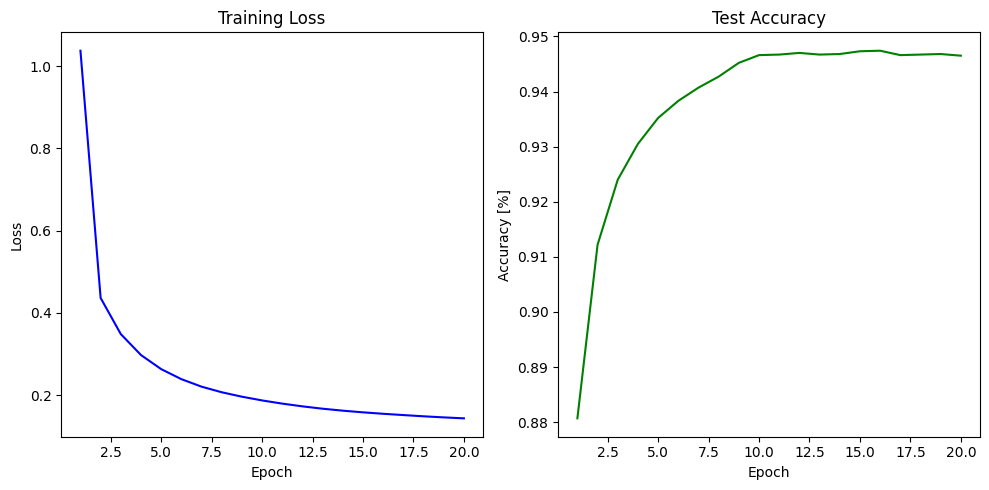

peak memory: 1646.50 MiB, increment: 0.03 MiB


In [ ]:
# Memory profiler for the ProxProp Network

layers = [784, 128, 64, 10]
n_epochs = 20
eta = 5.0
mini_batch_size = 100
network = ProxProp(layers)
%memit network.SGD((x_train, y_train), epochs=n_epochs, mini_batch_size=mini_batch_size, eta=eta, test_data=(x_test, y_test))

# peak memory: 1646.50 MiB, increment: 0.03 MiB